100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.23s/it]
C:\Users\sivad\AppData\Local\Temp\ipykernel_6752\1621472183.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df.label, palette='Set1')


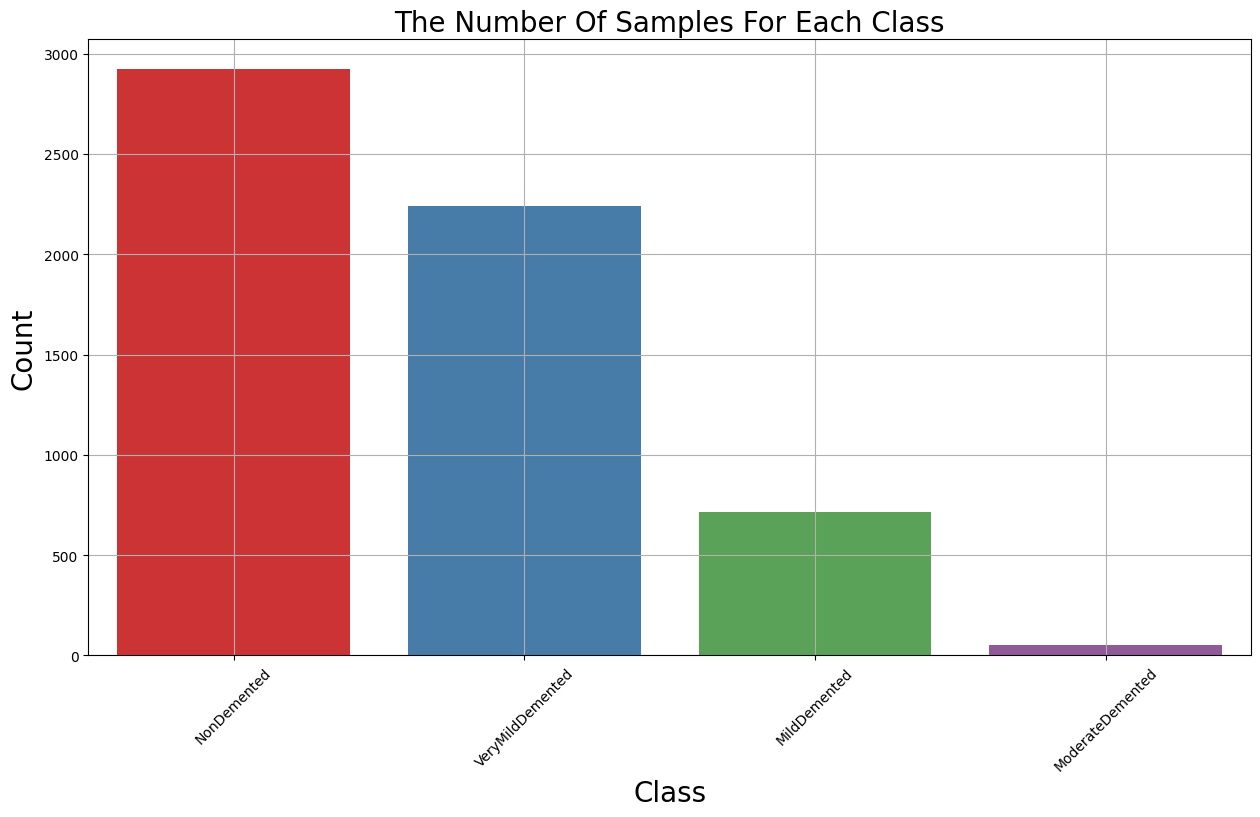

Found 4747 validated image filenames belonging to 4 classes.
Found 1187 validated image filenames belonging to 4 classes.



Epoch 1/10


149/149 [==============================] - 27s 156ms/step - loss: 0.9858 - accuracy: 0.5163 - val_loss: 0.9011 - val_accuracy: 0.5653
Epoch 2/10
149/149 [==============================] - 18s 119ms/step - loss: 0.8417 - accuracy: 0.6084 - val_loss: 0.8061 - val_accuracy: 0.6158
Epoch 3/10
149/149 [==============================] - 18s 120ms/step - loss: 0.7189 - accuracy: 0.6815 - val_loss: 0.7759 - val_accuracy: 0.6327
Epoch 4/10
149/149 [==============================] - 18s 119ms/step - loss: 0.5503 - accuracy: 0.7719 - val_loss: 0.5807 - val_accuracy: 0.7506
Epoch 5/10
149/149 [==============================] - 18s 119ms/step - loss: 0.3627 - accuracy: 0.8580 - val_loss: 0.4007 - val_accuracy: 0.8382
Epoch 6/10
149/149 [==============================] - 18s 119ms/step - loss: 0.2314 - accuracy: 0.9105 - val_loss: 0.4664 - val_accuracy: 0.8206
Epo

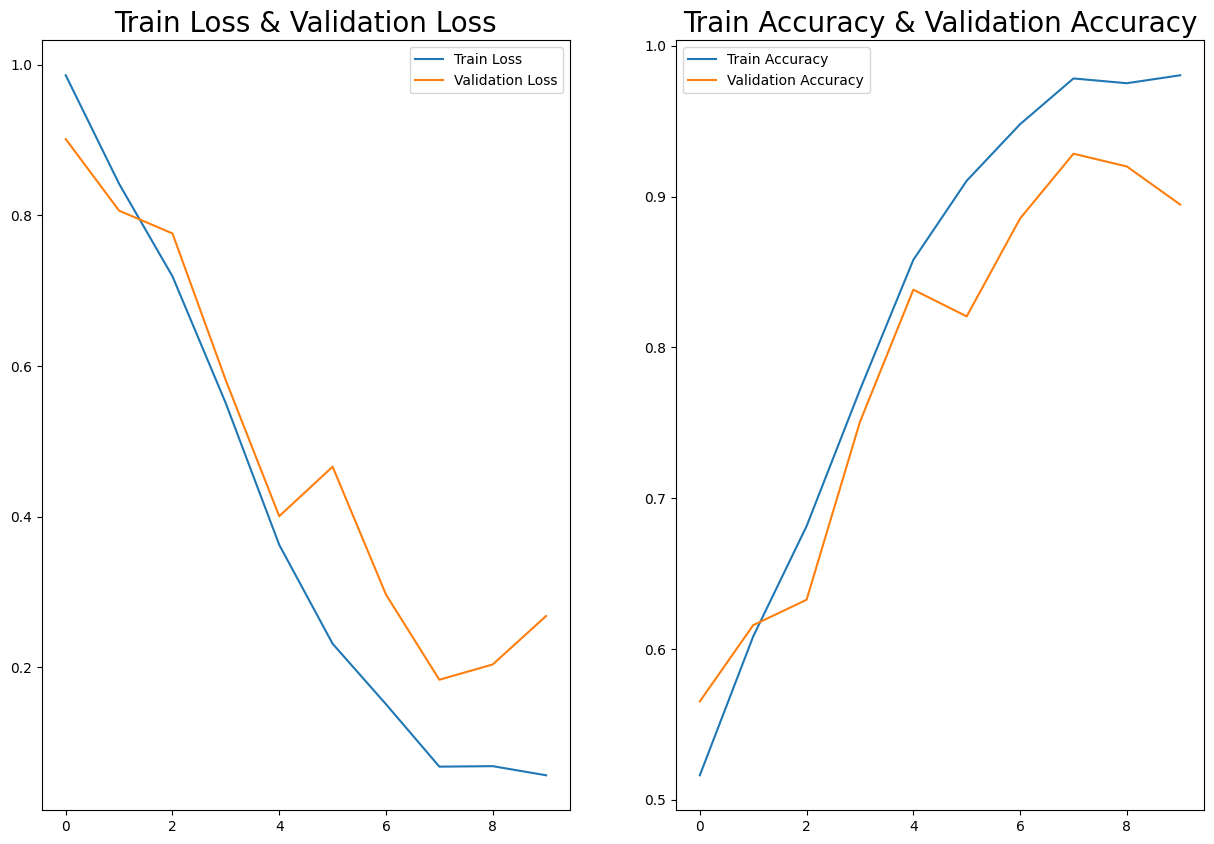

38/38 [==============================] - 3s 70ms/step - loss: 0.2682 - accuracy: 0.8947
Test Loss = 0.2682347297668457
Test Accuracy = 0.8946924805641174


In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Data Preparation
root_folder = 'C:\\Users\\sivad\\OneDrive\\Desktop\\mini project\\archive\\Alzheimer_s Dataset\\'
images = []
labels = []

# Collect image paths and labels
for subfolder in tqdm(os.listdir(root_folder)):
    subfolder_path = os.path.join(root_folder, subfolder)
    for folder in os.listdir(subfolder_path):
        folder_path = os.path.join(subfolder_path, folder)
        for image_filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_filename)
            if os.path.isfile(image_path):
                images.append(image_path)
                labels.append(folder)

# Create DataFrame
df = pd.DataFrame({'image': images, 'label': labels})

# Data Visualization
plt.figure(figsize=(15, 8))
ax = sns.countplot(x=df.label, palette='Set1')
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.title('The Number Of Samples For Each Class', fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# Image Augmentation and Preprocessing
Size = (176, 176)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=pd.DataFrame({'image': X_train, 'label': y_train}),
                                                    x_col='image',
                                                    y_col='label',
                                                    target_size=Size,
                                                    batch_size=32,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(dataframe=pd.DataFrame({'image': X_test, 'label': y_test}),
                                                  x_col='image',
                                                  y_col='label',
                                                  target_size=Size,
                                                  batch_size=32,
                                                  class_mode='categorical')

# Model Architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu', input_shape=(176, 176, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Model Compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Training
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=test_generator,
                    validation_steps=len(test_generator))

# Plotting Training and Validation Loss/Accuracy
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train Loss & Validation Loss', fontsize=20)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train Accuracy & Validation Accuracy', fontsize=20)
plt.legend()
plt.show()

# Model Evaluation
score, accuracy = model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', accuracy)


In [3]:
# Save the model architecture to JSON
model_json = model.to_json()
with open('alzheimer_model.json', 'w') as json_file:
    json_file.write(model_json)

# Save the model weights to HDF5
model.save_weights('alzheimer_model_weights.h5')


In [4]:
from tensorflow.keras.models import model_from_json

# Load the model architecture from JSON
with open('alzheimer_model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model weights
loaded_model.load_weights('alzheimer_model_weights.h5')


In [8]:
!pip install streamlit
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import model_from_json

# Load the model architecture from JSON
with open('alzheimer_model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model weights
loaded_model.load_weights('alzheimer_model_weights.h5')

# Define classes
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Function to predict
def predict(image):
    # Preprocess the image
    img = np.array(image.resize((176, 176))) / 255.0
    img = np.expand_dims(img, axis=0)

    # Make prediction
    prediction = loaded_model.predict(img)
    class_idx = np.argmax(prediction)
    confidence = prediction[0][class_idx]

    return classes[class_idx], confidence

# Streamlit UI
st.title('Alzheimer Classification App')

uploaded_file = st.file_uploader("Upload an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)
    st.write("")

    if st.button('Predict'):
        class_name, confidence = predict(image)
        st.write(f'Prediction: {class_name}, Confidence: {confidence:.2f}')


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB 991.0 kB/s eta 0:00:09
    --------------------------------------- 0.2/8.1 MB 1.8 MB/s eta 0:00:05
   - -------------------------------------- 0.3/8.1 MB 2.4 MB/s eta 0:00:04
   - -------------------------------------- 0.4/8.1 MB 2.3 MB/s eta 0:00:04
   -- ------------------------------------- 0.6/8.1 MB 2.5 MB/s eta 0:00:04
   --- ------------------------------------ 0.7/8.1 MB 2.7 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/8.1 MB 2.6 MB/s eta 0:00:03
   ---- ----------------------------------- 0.9/8.1 MB 2.5 MB/s eta 0:00:03
   ---- ----------------------------------- 0.9/8.1 MB 2.5 MB/s eta 0:00:03
   ---- ----------------------------------- 0.9/8.1 MB 2.5 MB/s eta 0:00:03
   ---- ----------------------------------- 0.9/8.1 MB 2.5 MB/s eta 0:00:03
   ---- -------

2024-04-24 16:10:50.074 
  command:

    streamlit run C:\Users\sivad\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [9]:
import tensorflow as tf

# Assuming you have trained your model and stored it in a variable named 'model'

# Save the model
# Save the model in the native Keras format
model.save('your_model.keras')



In [15]:

# Function to classify an image
def classify_image(image_path, model):
    # Preprocess the image
    img = preprocess_image(image_path)
    # Make prediction
    prediction = model.predict(img)
    # Get class label
    class_index = np.argmax(prediction[0])
    # Map class index to label
    labels = {0: 'mild demented', 1: 'modrate demented 1', 2: 'non demented', 3: 'very mild demented'}  # Modify according to your class labels
    class_label = labels[class_index]
    return class_label
# Path to the image you want to classify
input_image_path = "C:\\Users\\sivad\\OneDrive\\Desktop\\mini project\\archive\\Alzheimer_s Dataset\\train\\ModerateDemented\\moderateDem1.jpg"


# Classify the image
predicted_class = classify_image(input_image_path, model)
print('Predicted Class:', predicted_class)


1/1 [==============================] - 1s 560ms/step
Predicted Class: modrate demented 1


In [16]:
from flask import Flask, request, jsonify, render_template
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os

app = Flask(__name__)

# Load your trained CNN model
model = load_model('your_model.keras')  # Change 'your_model.h5' to the path of your model file

# Define a function to preprocess the image before feeding it to the model
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(176, 176))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Define a function to make predictions
def predict(image_path):
    img_array = preprocess_image(image_path)
    result = model.predict(img_array)
    return result

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def prediction():
    try:
        # Get the image file from the request
        image_file = request.files['image']

        # Save the image to a temporary location
        image_path = 'temp_image.jpg'
        image_file.save(image_path)

        # Make prediction
        prediction_result = predict(image_path)

        # Delete the temporary image file
        os.remove(image_path)

        # Get the predicted class
        predicted_class_index = np.argmax(prediction_result[0])
        class_labels = ['mild demented', 'moderate demented', 'non demented', 'very mild demented']
        predicted_class = class_labels[predicted_class_index]

        return render_template('result.html', predicted_class=predicted_class)
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1